# Introduction

Ensembling is a commonly used technique in Kaggle competitions to combine predictions of multiple models and get stronger predictions that hopefully achieve better score on the leaderboard. The idea is that combining different models with varying strengths and weaknesses can lead to better generalization on unseen data. There are various approaches to ensembling. In this notebook, we will explore a few of these approaches and evaluate their effectiveness in a regression task, and see how they compare to each other. While the focus in this notebook is on regression, with small adjustments, many of the techniques discussed here can be easily adapted for classification problems.

# Imports and configs

In [1]:
!pip install -q hillclimbers

In [2]:
from sklearn.ensemble import HistGradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import KFold
from sklearn.base import clone
from hillclimbers import climb_hill, partial
from category_encoders import TargetEncoder
from xgboost import XGBRFRegressor, XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import optuna
import shutil
import pickle
import gc
import os

warnings.filterwarnings('ignore')

In [3]:
class CFG:
    train_path = '/kaggle/input/playground-series-s4e9/train.csv'
    test_path = '/kaggle/input/playground-series-s4e9/test.csv'
    sample_sub_path = '/kaggle/input/playground-series-s4e9/sample_submission.csv'

    target = 'price'
    n_folds = 5
    seed = 228

# Data preprocessing and feature engineering

The dataset in this competition contains only two numerical features: `model_year` and `mileage`. The rest are categorical and need to be processed accordingly. Additionally, three of the columns—`fuel_type`, `clean_title`, and `accident`—contain missing values and need to be handled for models that can't deal with missing values on their own. We will also add some additional features and evaluate their usefulness with mutual information. 

Feature engineering is usually not used in playground competitions due to the synthetic nature of the dataset, which contains noise, and engineering new features often just adds to this noise. However, in this particular competition, I have seen improvements to the CV score when adding new features.

In [4]:
train = pd.read_csv(CFG.train_path, index_col='id')
test = pd.read_csv(CFG.test_path, index_col='id')

The `engine` column contains a lot of information about the car's engine, such as horsepower, size, number of cylinders, etc. Intuitively, this information affects car prices—cars with bigger engines, more horsepower, and more cylinders tend to be more expensive. Here, I have taken inspiration from [this discussion post](https://www.kaggle.com/competitions/playground-series-s4e9/discussion/531434#2977971) and added a few features based on the information available in the `engine` column.

In [5]:
def add_engine_features(df):
    cylinder_mapping = {
        'i4': '4',
        'v6': '6',
        'v8': '8',
        'v10': '10',
        'v12': '12'
    }
    df['engine'] = df['engine'].replace('–', np.nan)
    df['engine_lower'] = df['engine'].str.lower()
    df['horsepower'] = df['engine_lower'].str.extract(r'(\d+\.?\d*)hp', expand=False).astype(float)
    df['liters'] = df['engine'].str.extract(r'(\d+(\.\d+)?)\s*L(?:iter)?', expand=False)[0].astype(float)
    df['cylinders'] = df['engine_lower'].str.extract(r'\b(i4|v6|v8|v10|v12)\b', expand=False)
    df['cylinders'] = df['cylinders'].replace(cylinder_mapping)
    df['cylinders'] = df['cylinders'].fillna(df['engine_lower'].str.extract(r'(\d+)\s*cylinder', expand=False)).astype(float)
    df = df.drop('engine_lower', axis=1)

    return df

In [6]:
# train = add_engine_features(train)
# test = add_engine_features(test)

As shown in [this discussion post](https://www.kaggle.com/competitions/playground-series-s4e9/discussion/531698), there are interesting signals in the `ext_col` and `int_col` columns. Cars with 'metallic' or 'pearl' in their color name tend to have higher prices. In addition to incorporating these featuers, I have also added a feature that captures how many words are in the car's color name. My intuition is that colors with more fancier names tend to have more words, and therefore, cars with these colors may have higher prices.

In [7]:
def add_color_features(df):   
    df['is_metalic'] = df['ext_col'].str.lower().str.contains('metallic').astype(int)
    df['is_pearl'] = df['ext_col'].str.lower().str.contains('pearl').astype(int)
    df['ext_col'] = df['ext_col'].replace('–', '')
    df['words_in_ext_col'] = df['ext_col'].str.lower().str.split().apply(len)
    df['ext_col'] = df['ext_col'].replace('', np.nan)

    df['int_col'] = df['int_col'].replace('–', '')
    df['words_in_int_col'] = df['int_col'].str.lower().str.split().apply(len)
    df['int_col'] = df['int_col'].replace('', np.nan)  

    return df

In [8]:
# train = add_color_features(train)
# test = add_color_features(test)

The car's age also affects its price—older cars are usually cheaper. The age can be inferred from the `model_year`. 
I've also added a feature for how many miles a car has driven on average per year, which is another factor that influences the price.

In [9]:
def add_age_features(df):
    df['age'] = 2024 - df['model_year']
    df['age'] = df['age'].replace(0, 1)
    df['miles_per_year'] = df['milage'] // df['age']
    return df

In [10]:
# train = add_age_features(train)
# test = add_age_features(test)

As the final preprocessing step, I will impute the missing values in the categorical features with 'missing' and target encode these features. For the numerical features that have missing values, I will simply impute them with the mean value.

In [11]:
cat_cols = train.select_dtypes(include=['object']).columns.tolist()
num_cols = train.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_cols = [col for col in num_cols if col not in [CFG.target, 'id']]

for col in cat_cols:
    train[col] = train[col].fillna('missing')
    test[col] = test[col].fillna('missing')
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')
    
for col in num_cols:
    train[col] = train[col].fillna(train[col].mean())
    test[col] = test[col].fillna(train[col].mean())

In [12]:
encoder = TargetEncoder()
train[cat_cols] = encoder.fit_transform(train[cat_cols], train[CFG.target])
test[cat_cols] = encoder.transform(test[cat_cols])    

In [13]:
X = train.drop(CFG.target, axis=1)
y = train[CFG.target]
X_test = test.copy()

Here, we can see that the features we have created contain good signal, and can be used.

In [14]:
_X_mi = X.copy()

mutual_info = mutual_info_regression(_X_mi, y, random_state=CFG.seed)

mutual_info = pd.Series(mutual_info)
mutual_info.index = _X_mi.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns=['Mutual Information'])
mutual_info.style.bar(subset=['Mutual Information'], cmap='RdYlGn')

,Mutual Information
milage,0.659162
engine,0.609784
model_year,0.544162
transmission,0.444706
model,0.437193
clean_title,0.163645
brand,0.151283
ext_col,0.136787
int_col,0.130236
accident,0.064520


# Training base models

Here, I have created a class to train and cross-validate the base models. I will use this class to train all five of my base models, as well as some of the ensemble models. The class also contains a function that saves oof predictions of the base models. Feel free to use these OOF files in your own ensemble.

In [15]:
os.mkdir('oof_preds')
os.mkdir('test_preds')

In [16]:
class Trainer:
    def __init__(self, model, CFG, is_ensemble=False, save_preds=False):
        self.model = model
        self.config = CFG
        self.is_ensemble = is_ensemble
        self.save_preds = save_preds

    def fit_predict(self, X, y, X_test):
        print(f'Training {self.model.__class__.__name__}\n')
        
        scores = []        
        coeffs = np.zeros((1, X.shape[1]))
        oof_preds = np.zeros(len(X), dtype=np.float32)
        test_preds = np.zeros(len(X_test), dtype=np.float32)
        
        skf = KFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            model.fit(X_train, y_train)
            
            if self.is_ensemble:
                coeffs += model.coef_ / self.config.n_folds
            
            y_preds = model.predict(X_val)
            oof_preds[val_idx] = y_preds
            
            temp_test_preds = model.predict(X_test)
            test_preds += temp_test_preds / self.config.n_folds
            
            score = mean_squared_error(y_val, y_preds, squared=False)
            scores.append(score)
            
            del model, X_train, y_train, X_val, y_val, y_preds, temp_test_preds
            gc.collect()
            
            print(f'--- Fold {fold_idx + 1} - RMSE: {round(score)}')
            
        overall_score = mean_squared_error(y, oof_preds, squared=False)
        
        print(f'\nOverall RMSE: {round(overall_score)} ± {round(np.std(scores))}')
        
        if self.save_preds:
            self._save_preds(oof_preds, overall_score, 'oof')
            self._save_preds(test_preds, overall_score, 'test')
        
        if self.is_ensemble:
            return oof_preds, test_preds, scores, coeffs[0]
        else:
            return oof_preds, test_preds, scores
        
    def _save_preds(self, preds, cv_score, name):
        model_name = self.model.__class__.__name__.lower().replace('regressor', '')
        with open(f'{name}_preds/{model_name}_{name}_preds_{round(cv_score)}.pkl', 'wb') as f:
            pickle.dump(preds, f)

In [17]:
def save_submission(test_preds, name, score):
    sub = pd.read_csv(CFG.sample_sub_path)
    sub[CFG.target] = test_preds
    sub.to_csv(f'sub_{name}_{round(score)}.csv', index=False)
    return sub

In [18]:
lgbm_params = {
    'boosting_type': 'gbdt',
    'colsample_bytree': 0.40393559882328256,
    'learning_rate': 0.017738701693592488,
    'min_child_samples': 185,
    'min_child_weight': 0.656209628468257,
    'n_estimators': 231,
    'n_jobs': -1,
    'num_leaves': 83,
    'random_state': 228,
    'reg_alpha': 6.7373512856443805,
    'reg_lambda': 2.063542414559403,
    'subsample': 0.7169621141700278,
    'verbose': -1
}

xgb_params = {
    'colsample_bylevel': 0.13665282976246984,
    'colsample_bynode': 0.12605056749858132,
    'colsample_bytree': 0.9941217525562732,
    'gamma': 9.239828692282227,
    'learning_rate': 0.01262391624428664,
    'max_depth': 353,
    'max_leaves': 292,
    'min_child_weight': 122.81561865572444,
    'n_estimators': 617,
    'n_jobs': -1,
    'random_state': 228,
    'reg_alpha': 87.75157765322994,
    'reg_lambda': 7.721723554535909,
    'subsample': 0.9870379246817588,
    'verbosity': 0
}

xgbrf_params = {
    'colsample_bylevel': 0.9926650439792628,
    'colsample_bynode': 0.7650708472856718,
    'colsample_bytree': 0.8751058243688384,
    'gamma': 0.6241795915715864,
    'max_depth': 67,
    'min_child_weight': 57.058282876478934,
    'n_jobs': -1,
    'num_parallel_tree': 2705,
    'random_state': 228,
    'reg_alpha': 42.01217756370723,
    'reg_lambda': 0.912084080329384,
    'subsample': 0.5029448381425498,
    'verbosity': 0
}

cb_params = {
    'border_count': 252,
    'colsample_bylevel': 0.40061161445911886,
    'depth': 7,
    'iterations': 1264,
    'l2_leaf_reg': 6.719412529662209,
    'learning_rate': 0.018044156749677225,
    'loss_function': "RMSE",
    'min_child_samples': 38,
    'random_state': 228,
    'random_strength': 0.49384849397762776,
    'subsample': 0.5728869797927224,
    'verbose': False
}

hgb_params = {
    'l2_regularization': 30.379626515131864,
    'learning_rate': 0.057316365702868174,
    'max_depth': 465,
    'max_iter': 2837,
    'max_leaf_nodes': 23,
    'min_samples_leaf': 410,
    'random_state': 228
}

In [19]:
oof_preds = {}
test_preds = {}
scores = {}

In [20]:
lgbm_model = LGBMRegressor(**lgbm_params)
lgbm_trainer = Trainer(lgbm_model, CFG, save_preds=True)
oof_preds['LightGBM'], test_preds['LightGBM'], scores['LightGBM'] = lgbm_trainer.fit_predict(X, y, X_test)

Training LGBMRegressor

--- Fold 1 - RMSE: 71624
--- Fold 2 - RMSE: 72794
--- Fold 3 - RMSE: 72494
--- Fold 4 - RMSE: 71849
--- Fold 5 - RMSE: 73109

Overall RMSE: 72376 ± 560


In [21]:
xgb_model = XGBRegressor(**xgb_params)
xgb_trainer = Trainer(xgb_model, CFG, save_preds=True)
oof_preds['XGBoost'], test_preds['XGBoost'], scores['XGBoost'] = xgb_trainer.fit_predict(X, y, X_test)

Training XGBRegressor

--- Fold 1 - RMSE: 71651
--- Fold 2 - RMSE: 72817
--- Fold 3 - RMSE: 72339
--- Fold 4 - RMSE: 71683
--- Fold 5 - RMSE: 73092

Overall RMSE: 72319 ± 583


In [22]:
xgbrf_model = XGBRFRegressor(**xgbrf_params)
xgbrf_trainer = Trainer(xgbrf_model, CFG, save_preds=True)
oof_preds['XGBoost (RF)'], test_preds['XGBoost (RF)'], scores['XGBoost (RF)'] = xgbrf_trainer.fit_predict(X, y, X_test)

Training XGBRFRegressor

--- Fold 1 - RMSE: 71651
--- Fold 2 - RMSE: 72825
--- Fold 3 - RMSE: 72444
--- Fold 4 - RMSE: 71802
--- Fold 5 - RMSE: 73059

Overall RMSE: 72358 ± 552


In [23]:
cb_model = CatBoostRegressor(**cb_params)
cb_trainer = Trainer(cb_model, CFG, save_preds=True)
oof_preds['CatBoost'], test_preds['CatBoost'], scores['CatBoost'] = cb_trainer.fit_predict(X, y, X_test)

Training CatBoostRegressor

--- Fold 1 - RMSE: 71801
--- Fold 2 - RMSE: 72463
--- Fold 3 - RMSE: 72528
--- Fold 4 - RMSE: 71581
--- Fold 5 - RMSE: 73392

Overall RMSE: 72356 ± 636


In [24]:
hgb_model = HistGradientBoostingRegressor(**hgb_params)
hgb_trainer = Trainer(hgb_model, CFG, save_preds=True)
oof_preds['HistGB'], test_preds['HistGB'], scores['HistGB'] = hgb_trainer.fit_predict(X, y, X_test)

Training HistGradientBoostingRegressor

--- Fold 1 - RMSE: 71733
--- Fold 2 - RMSE: 72925
--- Fold 3 - RMSE: 72454
--- Fold 4 - RMSE: 71766
--- Fold 5 - RMSE: 73054

Overall RMSE: 72388 ± 557


# Ensembling base models

In [25]:
def plot_weights(title, weights):
    plt.figure(figsize=(10, 4))

    weights = pd.Series(weights, index=test_preds.keys()).sort_values(ascending=False)
    sns.barplot(y=weights.index, x=weights.values, palette='RdYlGn_r')
    plt.title(title)
    plt.ylabel('')
    plt.xlabel('')

    for i, (value, name) in enumerate(zip(weights, test_preds.keys())):
        if value > 0:
            plt.text(value, i, f'{value:.3f}', va='center', ha='left', color='black')
        else:
            plt.text(value, i, f'{value:.3f}', va='center', ha='right', color='black')

    xlim = plt.xlim()
    plt.xlim(xlim[0] - 1.2 * abs(xlim[0]), xlim[1] + 0.1 * abs(xlim[1]))

    plt.tight_layout()
    plt.show()

## Weighted Averaging

One simple way to combine the predictions of multiple models is to assign a weight to each model and take the weighted average of the predictions. To find the optimal weights, we can use a hyperparameter optimization tool such as Optuna. Here, I've defined an Optuna run that optimizes the weights assigned to each model based on the overall RMSE achieved for each set of weights.


In [26]:
def objective(trial):
    lgbm_weight = trial.suggest_float('lgbm_weight', 0.0, 1.0)
    xgb_weight = trial.suggest_float('xgb_weight', 0.0, 1.0)
    xgbrf_weight = trial.suggest_float('xgbrf_weight', 0.0, 1.0)
    cb_weight = trial.suggest_float('cb_weight', 0.0, 1.0)
    hgb_weight = trial.suggest_float('hgb_weight', 0.0, 1.0)

    weights = [
        lgbm_weight,
        xgb_weight,
        xgbrf_weight, 
        cb_weight, 
        hgb_weight
    ]
    weights /= np.sum(weights)

    preds = np.zeros((X.shape[0]))
    for model, weight in zip(oof_preds.keys(), weights):
        preds += oof_preds[model] * weight

    return mean_squared_error(preds, y, squared=False)

In [27]:
sampler = optuna.samplers.TPESampler(seed=CFG.seed)
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=500)

[I 2024-09-16 08:19:38,166] A new study created in memory with name: no-name-d0c9f26d-3f34-4c36-b685-32fbcc72a829
[I 2024-09-16 08:19:38,173] Trial 0 finished with value: 72275.3127128141 and parameters: {'lgbm_weight': 0.4238108114695278, 'xgb_weight': 0.5417427669021565, 'xgbrf_weight': 0.6885548977177369, 'cb_weight': 0.34608302515355915, 'hgb_weight': 0.4390290042342089}. Best is trial 0 with value: 72275.3127128141.
[I 2024-09-16 08:19:38,178] Trial 1 finished with value: 72296.72820345349 and parameters: {'lgbm_weight': 0.5890490882552291, 'xgb_weight': 0.6536621729379826, 'xgbrf_weight': 0.11026583566095016, 'cb_weight': 0.14290265496795074, 'hgb_weight': 0.8741773566676976}. Best is trial 0 with value: 72275.3127128141.
[I 2024-09-16 08:19:38,183] Trial 2 finished with value: 72274.59295802933 and parameters: {'lgbm_weight': 0.3370017886945007, 'xgb_weight': 0.0690762632890779, 'xgbrf_weight': 0.3119193394222002, 'cb_weight': 0.6127806231598824, 'hgb_weight': 0.6540414802670811

In [28]:
scores['Weighted Averaging'] = [study.best_value] * CFG.n_folds

In [29]:
best_weights = study.best_params
best_weights = [best_weights[f'{model}_weight'] for model in ['lgbm', 'xgb', 'xgbrf', 'cb', 'hgb']]
best_weights /= np.sum(best_weights)

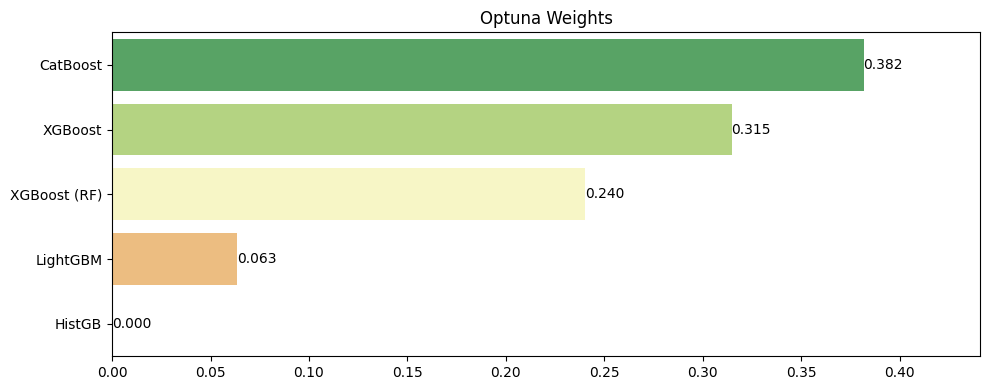

In [30]:
plot_weights('Optuna Weights', best_weights)

To make predictions with this 'model', we can simply use the weights that we found and take the weighted average of the test predictions of each base model.

In [31]:
weighted_test_preds = np.zeros((test.shape[0]))
for model, weight in zip(test_preds.keys(), best_weights):
    weighted_test_preds += test_preds[model] * weight

In [32]:
save_submission(weighted_test_preds, 'weighted-averaging', study.best_value).head()

,id,price
0,188533,16957.038544
1,188534,82339.869926
2,188535,52180.091732
3,188536,28530.255370
4,188537,30598.180711


## Ridge

Instead of tuning ensemble weights, we can use a meta-model that uses the predictions of the base models as features and learns the best way to combine them. The regularized linear model, Ridge, is a popular choice for this purpose. It learns a linear combination of the features and assigns weights to each model that minimizes its error. The L2 regularization term in Ridge penalizes large weights (coefficients), ensuring that no single model dominates the ensemble.

Since we are using the predictions as features, it is likely that these features are highly correlated with each other. Ridge is especially effective at handling this multicollinearity.

Before feeding the predictions to the model, I will create a dataframe out of the prediction and scale the values using `MinMaxScaler`. This gives a small boost to the CV score.

In [33]:
_X = pd.DataFrame(oof_preds)
_X_test = pd.DataFrame(test_preds)

scaler = MinMaxScaler().set_output(transform='pandas')
_X = scaler.fit_transform(_X)
_X_test = scaler.transform(_X_test)

In [34]:
ridge_model = Ridge()
ridge_trainer = Trainer(ridge_model, CFG, True)
_, ridge_test_preds, scores['Ridge'], ridge_coeffs = ridge_trainer.fit_predict(_X, y, _X_test)

Training Ridge

--- Fold 1 - RMSE: 71621
--- Fold 2 - RMSE: 72686
--- Fold 3 - RMSE: 72375
--- Fold 4 - RMSE: 71651
--- Fold 5 - RMSE: 73149

Overall RMSE: 72299 ± 593


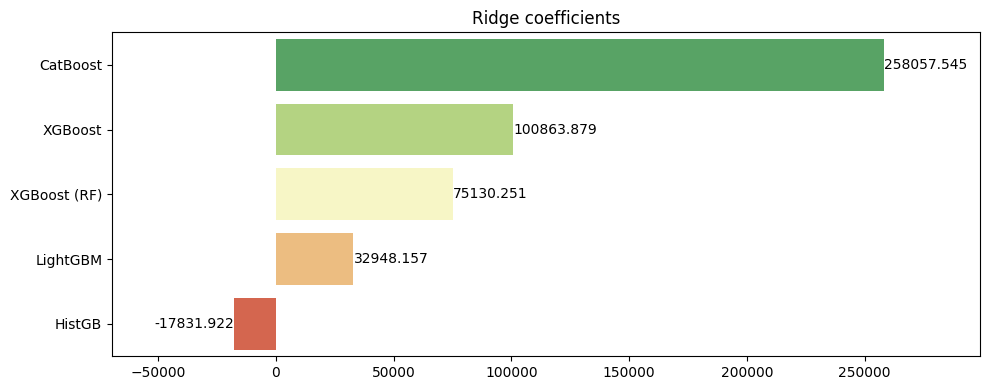

In [35]:
plot_weights('Ridge coefficients', ridge_coeffs)

In [36]:
save_submission(ridge_test_preds, 'ridge', np.mean(scores['Ridge'])).head()

,id,price
0,188533,16419.505859
1,188534,83983.054688
2,188535,52220.691406
3,188536,28589.988281
4,188537,30266.531250


## Lasso

Lasso is another good option when choosing a meta-model for ensembling. Similar to Ridge, Lasso is a regularized linear model. However, unlike Ridge, which includes an L2 regularization term, Lasso has an inbuilt L1 regularization. One interesting property of Lasso is that it can set a models weight to zero, meaning it essentially performs feature selection and discards the least useful features.

In [37]:
lasso_model = Lasso()
lasso_trainer = Trainer(lasso_model, CFG, True)
_, lasso_test_preds, scores['Lasso'], lasso_coeffs = lasso_trainer.fit_predict(_X, y, _X_test)

Training Lasso

--- Fold 1 - RMSE: 71626
--- Fold 2 - RMSE: 72688
--- Fold 3 - RMSE: 72378
--- Fold 4 - RMSE: 71648
--- Fold 5 - RMSE: 73159

Overall RMSE: 72302 ± 596


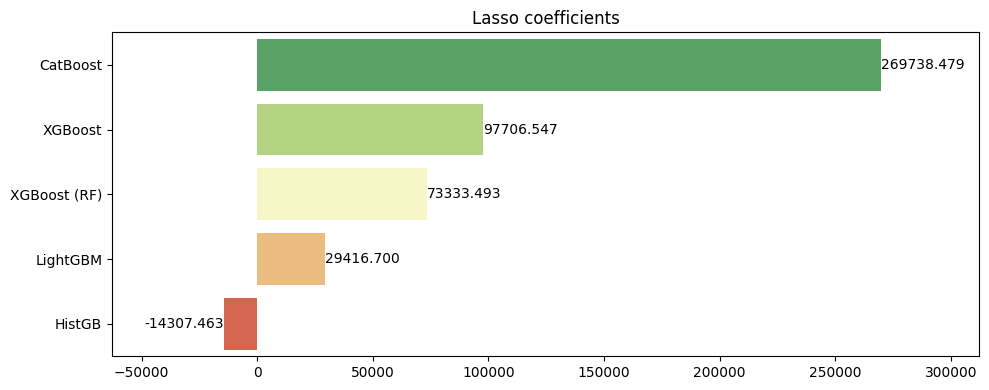

In [38]:
plot_weights('Lasso coefficients', lasso_coeffs)

In [39]:
save_submission(lasso_test_preds, 'lasso', np.mean(scores['Lasso'])).head()

,id,price
0,188533,16449.412109
1,188534,83745.429688
2,188535,52264.125000
3,188536,28539.117188
4,188537,30304.632812


## Hill climbing

In my opinion, hill climbing is an underused ensembling method in competitions. It is a simple, yet effective method to create an ensemble from OOF files. I will use the implementation from a fellow Kaggler. You can learn more about this library [here](https://github.com/Matt-OP/hillclimbers/).

In [40]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

In [41]:
hc_test_preds, hc_oof_preds = climb_hill(
    train=train, 
    oof_pred_df=pd.DataFrame(oof_preds), 
    test_pred_df=pd.DataFrame(test_preds),
    target=CFG.target,
    objective='minimize', 
    eval_metric=partial(rmse),
    negative_weights=True, 
    precision=0.001, 
    plot_hill=True, 
    plot_hist=False,
    return_oof_preds=True
)

   /\  
  /__\  hillclimbers 
 /    \
/______\ 

Models to be ensembled | (5 total): 

XGBoost:      72318.60799 (best solo model)
CatBoost:     72355.88526
XGBoost (RF): 72358.37124
LightGBM:     72376.02655
HistGB:       72388.48847

[Data preparation completed successfully] - [Initiate hill climbing] 

Iteration: 1 | Model added: CatBoost | Best weight: 0.432 | Best rmse: 72267.23454
Iteration: 2 | Model added: XGBoost (RF) | Best weight: 0.249 | Best rmse: 72255.96349
Iteration: 3 | Model added: HistGB | Best weight: -0.072 | Best rmse: 72255.35333
Iteration: 4 | Model added: LightGBM | Best weight: 0.056 | Best rmse: 72254.92998


In [42]:
hc_score = mean_squared_error(hc_oof_preds, y, squared=False)
scores['Hill Climbing'] = [hc_score] * CFG.n_folds

In [43]:
save_submission(hc_test_preds, 'hill-climbing', hc_score).head()

,id,price
0,188533,16809.089844
1,188534,82756.195312
2,188535,52080.832031
3,188536,28385.003906
4,188537,30472.876953


## Voting

The methods shown previously all use OOF predictions and are generally faster ways to ensemble. Voting, however, re-fits each model that it is given from scratch. The regression version of the voting model averages the predictions from the base models. It can also accept a list of weights and compute the weighted average. It is not very different from the simple averaging model shown earlier.

In [44]:
estimators = [
    ('LightGBM', lgbm_model),
    ('XGBoost', xgb_model),
    ('XGBoost(rf)', xgbrf_model),
    ('CatBoost', cb_model),
    ('HistGB', hgb_model),
]

In [45]:
voting_model = VotingRegressor(estimators=estimators)
voting_trainer = Trainer(voting_model, CFG)
_, voting_test_preds, scores['Voting'] = voting_trainer.fit_predict(X, y, X_test)

Training VotingRegressor

--- Fold 1 - RMSE: 71603
--- Fold 2 - RMSE: 72662
--- Fold 3 - RMSE: 72362
--- Fold 4 - RMSE: 71667
--- Fold 5 - RMSE: 73047

Overall RMSE: 72270 ± 561


In [46]:
save_submission(voting_test_preds, 'voting', np.mean(scores['Voting'])).head()

,id,price
0,188533,17300.671875
1,188534,83313.531250
2,188535,51707.992188
3,188536,29496.044922
4,188537,30529.115234


In [47]:
weighted_voting_model = VotingRegressor(estimators=estimators, weights=best_weights)
weighted_voting_trainer = Trainer(weighted_voting_model, CFG)
_, weighted_voting_test_preds, scores['Weighted Voting'] = weighted_voting_trainer.fit_predict(X, y, X_test)

Training VotingRegressor

--- Fold 1 - RMSE: 71619
--- Fold 2 - RMSE: 72570
--- Fold 3 - RMSE: 72352
--- Fold 4 - RMSE: 71618
--- Fold 5 - RMSE: 73101

Overall RMSE: 72254 ± 572


In [48]:
save_submission(weighted_voting_test_preds, 'weighted-voting', np.mean(scores['Weighted Voting'])).head()

,id,price
0,188533,16957.039062
1,188534,82339.867188
2,188535,52180.089844
3,188536,28530.253906
4,188537,30598.181641


## Stacking

Similar to a voting model, a stacking model re-fits a list of models from scratch, and ensembles their predictions. However, unlike voting, it is more complex and uses a meta-model to learn the best combination of the features instead of simply averaging the predictions. Under the hood, it uses `RidgeCV` to ensemble predictions of the base models, however, its meta-model is configurable and can be changed. Here, I will just leave it with the default parameters.

In [49]:
stacking_model = StackingRegressor(estimators=estimators)
stacking_trainer = Trainer(stacking_model, CFG)
_, stacking_test_preds, scores['Stacking'] = stacking_trainer.fit_predict(X, y, X_test)

Training StackingRegressor

--- Fold 1 - RMSE: 71637
--- Fold 2 - RMSE: 72783
--- Fold 3 - RMSE: 72389
--- Fold 4 - RMSE: 71710
--- Fold 5 - RMSE: 73184

Overall RMSE: 72343 ± 600


In [50]:
save_submission(stacking_test_preds, 'stacking', np.mean(scores['Stacking'])).head()

,id,price
0,188533,16976.775391
1,188534,82286.851562
2,188535,52486.304688
3,188536,29086.115234
4,188537,30606.152344


# Results

We can see that all of the ensemble models achieve better scores than the individual models. The difference is not much, but it is enough to give you an edge in the competition. 

We can also see that the models that average the prediction are slightly better than the models that use a meta-model. This is not a general outcome that is expected, but just a result that is achieved on this dataset. Some ensembling methods work better than others, and there are no general rules for what works best. One has to experiment with different methods and choose an ensembling technique that suits the competition.

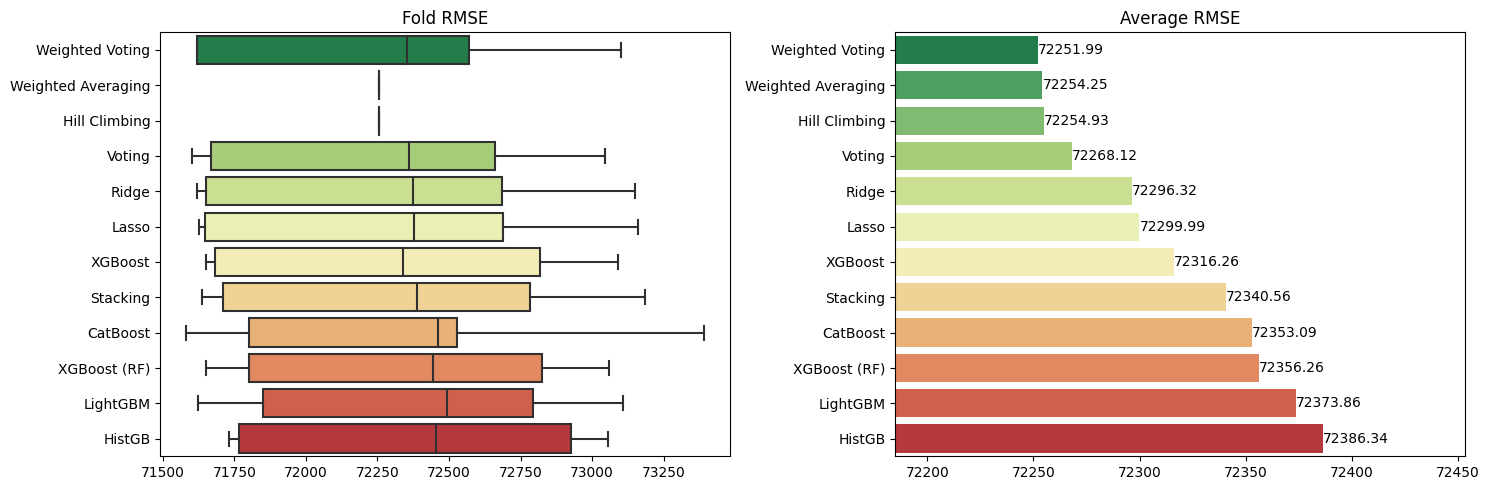

In [51]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=True)
order = scores.mean().sort_values(ascending=True).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=scores, order=order, ax=axs[0], orient='h', palette="RdYlGn_r")
axs[0].set_title('Fold RMSE')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], palette="RdYlGn_r")
axs[1].set_title('Average RMSE')
axs[1].set_xlabel('')
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel('')

for i, score in enumerate(mean_scores.values):
    barplot.text(score, i, round(score, 2), va='center')

plt.tight_layout()
plt.show()

In [52]:
shutil.rmtree('catboost_info')